Load Julia packages (libraries) needed

In [1]:
using StatisticalRethinking, CmdStan
#gr(size=(600,600));

┌ Info: Recompiling stale cache file /Users/rob/.julia/compiled/v1.3/CmdStan/jeIFm.ji for CmdStan [593b3428-ca2f-500c-ae53-031589ec8ddd]
└ @ Base loading.jl:1240


CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "02")
cd(ProjDir)

Define the Stan language model

In [3]:
binomialstanmodel = "
// Inferring a Rate
data {
  int N;
  int<lower=0> k[N];
  int<lower=1> n[N];
}
parameters {
  real<lower=0,upper=1> theta;
  real<lower=0,upper=1> thetaprior;
}
model {
  // Prior Distribution for Rate Theta
  theta ~ beta(1, 1);
  thetaprior ~ beta(1, 1);

  // Observed Counts
  k ~ binomial(n, theta);
}
";

Define the Stanmodel and set the output format to :mcmcchains.

In [4]:
stanmodel = Stanmodel(name="binomial", monitors = ["theta"], model=binomialstanmodel,
  output_format=:mcmcchains);


File /Users/rob/.julia/dev/StatisticalRethinking/scripts/02/tmp/binomial.stan will be updated.



Use 16 observations

In [5]:
N2 = 15
d = Binomial(9, 0.66)
n2 = Int.(9 * ones(Int, N2));

Show first 5 (generated) observations

In [6]:
k2 = rand(d, N2);
k2[1:min(5, N2)]

5-element Array{Int64,1}:
 7
 5
 4
 7
 7

Input data for cmdstan

In [7]:
binomialdata = Dict("N" => length(n2), "n" => n2, "k" => k2);

Sample using cmdstan

In [8]:
rc, chn, cnames = stan(stanmodel, binomialdata, ProjDir, diagnostics=false,
  CmdStanDir=CMDSTAN_HOME);

Inference for Stan model: binomial_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.029, 0.027, 0.025, 0.027) seconds, 0.11 seconds total
Sampling took (0.045, 0.042, 0.043, 0.045) seconds, 0.18 seconds total

                Mean     MCSE  StdDev     5%   50%   95%    N_Eff  N_Eff/s    R_hat
lp__             -90  2.7e-02     1.1    -92   -90   -89  1.6e+03  9.1e+03  1.0e+00
accept_stat__   0.91  1.7e-03    0.12   0.66  0.96   1.0  4.9e+03  2.8e+04  1.0e+00
stepsize__      0.84  2.3e-02   0.033   0.80  0.85  0.89  2.0e+00  1.1e+01  2.3e+13
treedepth__      2.0  1.2e-02    0.67    1.0   2.0   3.0  3.4e+03  1.9e+04  1.0e+00
n_leapfrog__     5.1  2.1e-01      12    1.0   3.0    15  3.5e+03  2.0e+04  1.0e+00
divergent__     0.00      nan    0.00   0.00  0.00  0.00      nan      nan      nan
energy__          91  3.9e-02     1.5     89    91    94  1.4e+03  8.1e+03  1.0e+00
theta           0.66  6.8e-04   0.040   

Describe the draws

In [9]:
describe(chn)

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters │ mean     │ std       │ naive_se    │ mcse        │
│     │ Symbol     │ Float64  │ Float64   │ Float64     │ Float64     │
├─────┼────────────┼──────────┼───────────┼─────────────┼─────────────┤
│ 1   │ theta      │ 0.663524 │ 0.0395501 │ 0.000625341 │ 0.000781703 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%    │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64  │ Float64  │ Float64  │ Float64  │ Float64  │
├─────┼────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 1   │ theta      │ 0.585286 │ 0.636262 │ 0.664682 │ 0.691837 │ 0.735295 │


Allocate array of Normal fits

In [10]:
fits = Vector{Normal{Float64}}(undef, 4)
for i in 1:4
  fits[i] = fit_mle(Normal, convert.(Float64, chn.value[:, 1, i]))
  println(fits[i])
end

Normal{Float64}(μ=0.6655353909999996, σ=0.03932328305195432)
Normal{Float64}(μ=0.6629714870000004, σ=0.03973425216429561)
Normal{Float64}(μ=0.6616857999999998, σ=0.038377249892299486)
Normal{Float64}(μ=0.6639053109999994, σ=0.040613362273619745)


Plot the 4 chains

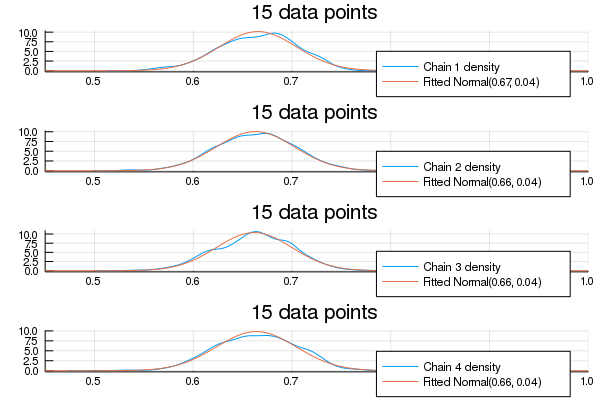

In [11]:
mu_avg = sum([fits[i].μ for i in 1:4]) / 4.0;
sigma_avg = sum([fits[i].σ for i in 1:4]) / 4.0;

if rc == 0
  p = Vector{Plots.Plot{Plots.GRBackend}}(undef, 4)
  x = 0:0.001:1
  for i in 1:4
    vals = convert.(Float64, chn.value[:, 1, i])
    μ = round(fits[i].μ, digits=2)
    σ = round(fits[i].σ, digits=2)
    p[i] = density(vals, lab="Chain $i density",
       xlim=(0.45, 1.0), title="$(N2) data points")
    plot!(p[i], x, pdf.(Normal(fits[i].μ, fits[i].σ), x), lab="Fitted Normal($μ, $σ)")
  end
  plot(p..., layout=(4, 1))
  #savefig("m2.1s.pdf")
end

Show the hpd region

In [12]:
hpd(chn, alpha=0.055)

HPD

│ Row │ parameters │ upper   │ lower    │
│     │ Symbol     │ Float64 │ Float64  │
├─────┼────────────┼─────────┼──────────┤
│ 1   │ theta      │ 0.59107 │ 0.736693 │

Compute the hpd bounds for plotting

In [13]:
d, p, c = size(chn);
theta = convert(Vector{Float64}, reshape(chn.value, (d*p*c)));
bnds = quantile(theta, [0.045, 0.945])

2-element Array{Float64,1}:
 0.596001245       
 0.7244636449999999

Show hpd region

In [14]:
println("hpd bounds = $bnds\n")

hpd bounds = [0.596001245, 0.7244636449999999]



quadratic approximation

Compute MAP, compare with CmndStan & MLE

In [15]:
tmp = convert(Array{Float64,3}, chn.value)
draws = reshape(tmp, (size(tmp, 1)*size(tmp, 3)),)

4000-element Array{Float64,1}:
 0.721971
 0.622055
 0.577651
 0.575187
 0.617232
 0.668251
 0.646222
 0.640851
 0.706258
 0.652434
 ⋮       
 0.685251
 0.644364
 0.66651 
 0.678132
 0.726723
 0.643749
 0.64739 
 0.670624
 0.679451

Compute MAP

In [16]:
using Optim

x0 = [0.5]
lower = [0.2]
upper = [1.0]

inner_optimizer = GradientDescent()

function loglik(x)
  ll = 0.0
  ll += log.(pdf.(Beta(1, 1), x[1]))
  ll += sum(log.(pdf.(Binomial(9, x[1]), k2)))
  -ll
end

res = optimize(loglik, lower, upper, x0, Fminbox(inner_optimizer))

 * Status: success

 * Candidate solution
    Minimizer: [6.67e-01]
    Minimum:   2.614351e+01

 * Found with
    Algorithm:     Fminbox with Gradient Descent
    Initial Point: [5.00e-01]

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 5.87e-10 ≤ 1.0e-08

 * Work counters
    Iterations:    4
    f(x) calls:    87
    ∇f(x) calls:   87


Summarize mean and sd estimates

CmdStan mean and sd:

In [17]:
[mean(chn.value), std(chn.value)]

2-element Array{Float64,1}:
 0.66352449725     
 0.0395500614334648

MAP estimate and associated sd:

In [18]:
[Optim.minimizer(res)[1], std(draws, mean=mean(chn.value))]

2-element Array{Float64,1}:
 0.6666666666232594
 0.0395500614334648

MLE of mean and sd:

In [19]:
[mu_avg, sigma_avg]

2-element Array{Float64,1}:
 0.6635244972499997 
 0.03951203684554229

Turing Chain &  89% hpd region boundaries

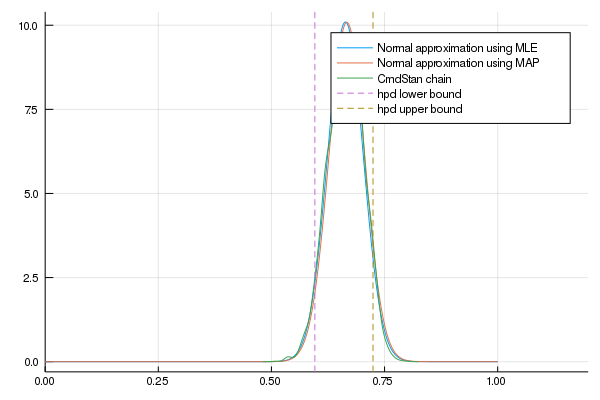

In [20]:
plot( x, pdf.(Normal( mu_avg , sigma_avg  ) , x ),
xlim=(0.0, 1.2), lab="Normal approximation using MLE")
plot!( x, pdf.(Normal( Optim.minimizer(res)[1] , std(draws, mean=mean(chn.value))) , x),
lab="Normal approximation using MAP")
density!(draws, lab="CmdStan chain")
vline!([bnds[1]], line=:dash, lab="hpd lower bound")
vline!([bnds[2]], line=:dash, lab="hpd upper bound")

End of `02/clip_08s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*